### Sample SQL query to get golfer handicapping data

Save query results to CSV file: `./handicap_data/handicap_data_golfer_###.csv`

```sql
SELECT golfer.id as golfer_id, golfer.name as golfer_name,
	roundgolferlink.playing_handicap, course.name as course_name,
	track.name as track_name, tee.id as tee_id, tee.name as tee_name,
	tee.rating, tee.slope, round.id as round_id, round.date_played,
	round.type as round_type, round.scoring_type as round_scoring_type,
	holeresult.id as holeresult_id, hole.number, hole.par, hole.yardage,
	holeresult.handicap_strokes, holeresult.gross_score,
	holeresult.adjusted_gross_score, holeresult.net_score
FROM public.round
INNER JOIN public.roundgolferlink ON roundgolferlink.round_id = round.id
INNER JOIN public.golfer ON golfer.id = roundgolferlink.golfer_id
INNER JOIN public.holeresult ON holeresult.round_id = round.id
INNER JOIN public.hole ON hole.id = holeresult.hole_id
INNER JOIN public.tee ON tee.id = round.tee_id
INNER JOIN public.track ON track.id = tee.track_id
INNER JOIN public.course ON course.id = track.course_id
WHERE public.golfer.name LIKE 'Jeremy Sotzen'
ORDER BY round.date_played, hole.number;
```

### Sample SQL query to get golfer qualifying scores

Save query results to CSV file: `./handicap_data/qualifying_scores_golfer_###.csv`

```sql
SELECT golfer.id as golfer_id, golfer.name as golfer_name,
	qualifyingscore.id as qualifyingscore_id, qualifyingscore.type,
	qualifyingscore.year,
	qualifyingscore.date_played, qualifyingscore.course_name,
	qualifyingscore.track_name,	qualifyingscore.tee_name,
	qualifyingscore.tee_rating, qualifyingscore.tee_slope,
	qualifyingscore.tee_par, qualifyingscore.gross_score,
	qualifyingscore.adjusted_gross_score, qualifyingscore.score_differential
FROM public.qualifyingscore
INNER JOIN public.golfer ON golfer.id = qualifyingscore.golfer_id
WHERE public.golfer.name LIKE 'Jeremy Sotzen'
ORDER BY qualifyingscore.date_played;
```

In [18]:
# LOAD HANDICAP DATA FROM FILE

from dataclasses import dataclass
from datetime import datetime

import numpy as np
import pandas as pd


# TODO: Copied from APLLegacyHandicapSystem class, consolidate
def compute_handicap_index(record: list[float]) -> float:
    # Reference: APL Golf League Handicapping
    record_sorted = np.sort(record)
    if len(record) < 4:
        score_diffs_avg = record_sorted[0]
    elif len(record) < 6:
        score_diffs_avg = np.mean(record_sorted[0:2])
    elif len(record) < 8:
        score_diffs_avg = np.mean(record_sorted[0:3])
    elif len(record) < 10:
        score_diffs_avg = np.mean(record_sorted[0:4])
    else:
        score_diffs_avg = np.mean(record_sorted[0:5])
    return min(
        np.floor((0.96 * score_diffs_avg) * 10.0) / 10.0,
        30,  # max handicap index allowed, from APLLegacyHandicapSystem
    )  # truncate to nearest tenth


@dataclass
class HoleHandicapData:
    holeresult_id: int
    number: int
    par: int
    yardage: int
    handicap_strokes: int
    gross_score: int
    adjusted_gross_score: int
    net_score: int


@dataclass
class RoundHandicapData:
    round_id: int
    golfer_id: int
    tee_id: int
    date_played: datetime
    course_name: str
    track_name: str
    tee_name: str
    rating: float
    slope: float
    holes: list[HoleHandicapData]

    @property
    def par(self) -> int:
        return sum(h.par for h in self.holes)

    @property
    def gross_score(self) -> int:
        return sum(h.gross_score for h in self.holes)

    @property
    def gross_score_to_par(self) -> int:
        return self.gross_score - self.par

    @property
    def adjusted_gross_score(self) -> int:
        return sum(h.adjusted_gross_score for h in self.holes)

    @property
    def net_score(self) -> int:
        return sum(h.net_score for h in self.holes)

    @property
    def scoring_differential(self) -> float:
        return (113 / self.slope) * (self.adjusted_gross_score - self.rating)


@dataclass
class HandicapIndex:
    date_posted: datetime
    rounds: list[RoundHandicapData]

    @property
    def index(self) -> float:
        return compute_handicap_index(
            record=[r.scoring_differential for r in self.rounds]
        )


DATA_FILE = "./handicap_data/handicap_data_golfer_003.csv"
df = pd.read_csv(DATA_FILE)

round_data: list[RoundHandicapData] = []
handicap_indexes: list[HandicapIndex] = []

for round_id, round_df in df.groupby("round_id"):
    round_holes: list[HoleHandicapData] = []
    for idx, round_row in round_df.iterrows():
        round_holes.append(
            HoleHandicapData(
                holeresult_id=round_row["holeresult_id"],
                number=round_row["number"],
                par=round_row["par"],
                yardage=round_row["yardage"],
                handicap_strokes=round_row["handicap_strokes"],
                gross_score=round_row["gross_score"],
                adjusted_gross_score=round_row["adjusted_gross_score"],
                net_score=round_row["net_score"],
            )
        )

    round_data.append(
        RoundHandicapData(
            round_id=round_df.iloc[0]["round_id"],
            golfer_id=round_df.iloc[0]["golfer_id"],
            tee_id=round_df.iloc[0]["tee_id"],
            date_played=pd.to_datetime(round_df.iloc[0]["date_played"]),
            course_name=round_df.iloc[0]["course_name"],
            track_name=round_df.iloc[0]["track_name"],
            tee_name=round_df.iloc[0]["tee_name"],
            rating=round_df.iloc[0]["rating"],
            slope=round_df.iloc[0]["slope"],
            holes=round_holes,
        )
    )

    print(
        f"{round_data[-1].date_played.strftime("%Y-%m-%d")} | {round_data[-1].gross_score} ({round_data[-1].gross_score_to_par:+3d}) | {round_data[-1].scoring_differential:5.2f} | {round_data[-1].course_name}, {round_data[-1].track_name}, {round_data[-1].tee_name}"
    )

    if len(round_data) > 10:  # TODO: un-hardcode
        rounds_in_scoring_record = round_data[-10:]
    else:
        rounds_in_scoring_record = round_data[:]

    handicap_indexes.append(
        HandicapIndex(
            date_posted=round_data[-1].date_played, rounds=rounds_in_scoring_record
        )
    )
    print(f"Handicap Index: {handicap_indexes[-1].index:.1f}")

2021-04-28 | 44 ( +9) |  8.47 | Diamond Ridge Golf Course, Front, White
Handicap Index: 8.1
2021-05-12 | 45 (+10) |  9.36 | Diamond Ridge Golf Course, Front, White
Handicap Index: 8.1
2021-06-16 | 43 ( +8) |  7.57 | Diamond Ridge Golf Course, Front, White
Handicap Index: 7.2
2021-06-23 | 47 (+12) | 11.16 | Diamond Ridge Golf Course, Front, White
Handicap Index: 7.6
2021-06-28 | 40 ( +5) |  4.88 | Diamond Ridge Golf Course, Front, White
Handicap Index: 5.9
2021-07-07 | 40 ( +5) |  4.88 | Diamond Ridge Golf Course, Front, White
Handicap Index: 5.5
2021-08-23 | 44 ( +9) |  8.47 | Diamond Ridge Golf Course, Front, White
Handicap Index: 5.5
2021-08-25 | 38 ( +3) |  3.09 | Diamond Ridge Golf Course, Front, White
Handicap Index: 4.8
2021-08-31 | 43 ( +8) |  7.57 | Diamond Ridge Golf Course, Front, White
Handicap Index: 4.8
2021-05-04 | 44 ( +8) |  7.65 | Timbers at Troy Golf Course, Front, Blue
Handicap Index: 5.3
2021-06-01 | 45 ( +9) |  8.50 | Timbers at Troy Golf Course, Front, Blue
Handic

(0.0, 10.0)

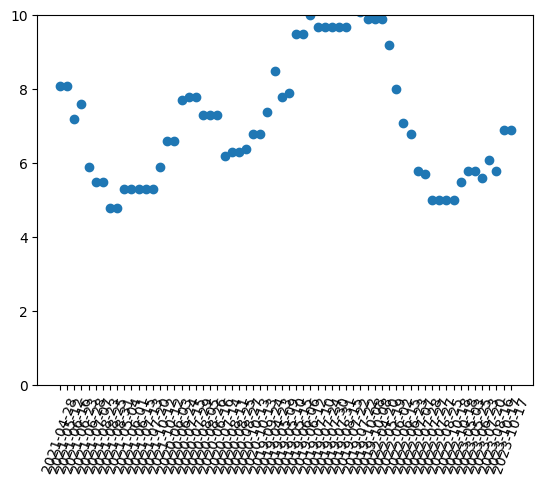

In [19]:
from matplotlib import pyplot as plt

plt.scatter(
    [num for num in range(1, len(handicap_indexes) + 1)],
    [h.index for h in handicap_indexes],
)
plt.xticks(
    [num for num in range(1, len(handicap_indexes) + 1)],
    [h.date_posted.strftime("%Y-%m-%d") for h in handicap_indexes],
    rotation=70,
)
plt.ylim(0, 10)